In [1]:
%matplotlib inline
from matplotlib import pyplot as pp
import numpy as np

# Introduction

Let's assume that we are given the function $f(\mathbf{x}) : \mathbb{R}^M \rightarrow \mathbb{R}$. At each point $\mathbf{x}$ this function produces the value $y = f(\mathbf{x})$. Due to real world circumstances, this assignment is usually noisy, meaning that for a point $\mathbf{x}$ rather than measuring $y$, we obtain a slightly misplaced value $\hat{y}$ calculated as
\begin{equation}
    \hat{y} = f(\mathbf{x}) + \mathcal{N}(0,\sigma^2).
\end{equation}
Here $\mathcal{N}(0,\sigma^2)$, is the normal distribution with mean $0$ and standard deviation $\sigma^2$. Here we will refere to each $(\mathbf{x},\hat{y})$ as a data point. This term is referred as Gaussian noise. Now given a set of data points $\{(\mathbf{x}_n,\hat{y}_n)\}_{n=1}^{N}$, our goal is to find a function $g(\mathbf{x}) : \mathbb{R}^M \rightarrow \mathbb{R}$ that approximates $f$ as close as possible. In other words, we would like to find the function $g$ such that
\begin{equation}
    \| g(\mathbf{x}) - f(\mathbf{x}) \|^2
\end{equation}
is minimized.

In [2]:
# This class contains the dataset

class dataset:
    def _build_dataset( self ):
        self._content = []
        for i in range( self.N ):
            x = np.random.uniform( self.I0, self.I1 )
            y = self.func( x )
            y_n = y + np.random.normal( 0, self.noise_std )
            self._content.append( [ x,y,y_n ] )
        self._content = np.array( self._content )
        
    def _build_dataset_dense( self ):
        x = np.arange( self.I0, self.I1, ( self.I1 - self.I0 )/(self.N_dense+1) )
        y = self.func( x )
        
        arr = np.array( [ x, y ] )
        self._content_dense = arr.transpose()
            
        
    def __init__( self ):
        self.func = np.sin
        self.N = 20
        self.N_dense = 100
        self.noise_std = 0.2
        
        self.I0 = -1*np.pi
        self.I1 = np.pi
        
        self._build_dataset()
        self._build_dataset_dense()
        
    @property
    def x( self ):
        return self._content[:,0].ravel()
    
    @property
    def y( self ):
        return self._content[:,1].ravel()
    
    @property
    def y_n( self ):
        return self._content[:,2].ravel()
    
    @property
    def x_dense( self ):
        return self._content_dense[:,0].ravel()
    
    @property
    def y_dense( self ):
        return self._content_dense[:,1].ravel()
        
dset = dataset()

# Sinus Curve

Let $f(x) = \sin(x)$ for the values in the interval $[-\pi,\pi]$. The goal of this section is to reproduce the red data points given the blue plot data points. To achieve this goal we will be looking at two different ways of modeling the data.

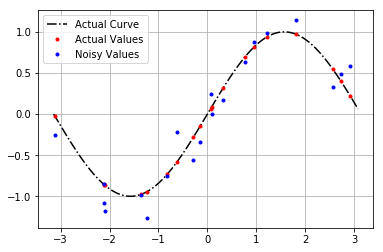

In [3]:
pp.plot( dset.x_dense, dset.y_dense,'k-.', label='Actual Curve' )
pp.plot( dset.x, dset.y, 'r.', label='Actual Values')
pp.plot( dset.x, dset.y_n, 'b.', label='Noisy Values')
pp.legend()
pp.grid()

## Polynomial Curve-Fitting

We can assume that $g$ belongs to the class of polynomial functions of the degree $D$. This gives $g$ the form of
\begin{equation}
    g(x) = \sum_{d=0}^{D} a_d x^d.
\end{equation}
To find $g$ we have to determine that values of $a_0, \dots, a_D$. For each $x_n$ we have the following equation
\begin{equation}
    \sum_{d=0}^{D} a_d x_n^d = \hat{y}_n,
\end{equation}
and this yields to a system of linear equations from which values of $a_0, \dots, a_D$ can be calculated. We assume that this system has the form of $Xa=Y$ and the matrices $X \in \mathbb{R}^{(N,D)}$ and $Y\in \mathbb{R}^{(N,1)}$ as calculated as following :

In [4]:
D = 5

X = np.zeros((dset.N,D+1))
Y = np.zeros((dset.N,1))

for i in range( dset.N ):
    Y[i,0] = dset.y_n[i]
    for d in range( D+1 ):
        X[i,d] = dset.x[i] ** d
        
X = np.matrix( X )
Y = np.matrix( Y )

One solution to this system is obtained by $a = (X^TX)^{-1}X^{T}Y$.

In [5]:
a = np.linalg.inv( X.T * X ) * X.T * Y
a = np.array( a )
a = a.ravel()
print( a )

[-0.00933626  1.0647227  -0.04343132 -0.17778385  0.00544987  0.00821083]


Now given $a$ for every $x$ we can calculate the value of $g(x)$. We will do so for the values of x_dense.

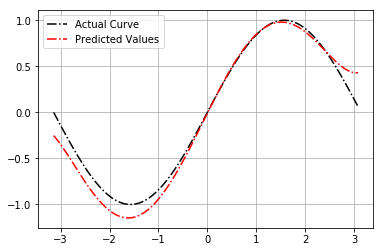

In [6]:
def g(x,D,a) :
    o = 0.0
    for d in range(D+1):
        o += a[d] * x ** d
    return o

y_pred = []
for p in dset.x_dense :
    y_pred.append( g(p,D,a) )
y_pred = np.array( y_pred )

pp.plot( dset.x_dense,dset.y_dense,'k-.', label='Actual Curve' )
pp.plot( dset.x_dense, y_pred, 'r-.', label='Predicted Values')
pp.legend()
pp.grid()

### Questions

1. How does changing $N$ and $D$ change the shape of the predicted curve?
2. Can we do this for some other functions? Lienar/Non-linear
3. How else can we obtain $a$?
4. How can we measure the error of this prediction?

## Radial Basis Function Kernel Curve Fitting (RBF Kernel)

Similar to polynomial curve fitting, our goal here to obtain the parameters of the predicted curve by solving a system of linear equations. Here, we will solve this problem by placing a basis function at each data point and formulate the predicted curve as a weighted sum of the basis functions. The Radial Basis funciton kernel has the form of 
\begin{equation}
    k(x,x') = \exp(- \frac{\|x-x'\|^2}{2\sigma^2}).
\end{equation}
At each point the shape of this kernel is as following :

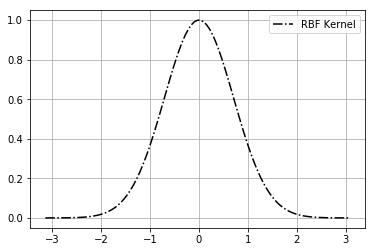

In [7]:
def rbf( x, x_base, sigma2 ):
    return np.exp(-1* (( x-x_base )**2) / (2*sigma2) )

kernal_sigma2 = 0.5
x_base = 0

y_rbf = []
for x in dset.x_dense :
    y_rbf.append( rbf(x, x_base, kernal_sigma2) )
    
pp.plot( dset.x_dense,y_rbf,'k-.', label='RBF Kernel' )
pp.legend()
pp.grid()

Placing this function at each data point and calculating a weighted sum will give us 
\begin{equation}
    g(x) = \sum_{n=1}^{N} a_n k(x,x_n).
\end{equation}
This sum again provides us with a system of linear equations with the form a $Ka=Y$ where $K \in \mathbb{R}^{(N,N)}$ and $Y \in \mathbb{R}^{(N,1)}$ and they are calculated as :

In [8]:
K = np.zeros((dset.N,dset.N))
Y = np.zeros((dset.N,1))

for i in range( dset.N ):
    Y[i,0] = dset.y_n[i]
    for j in range( dset.N ):
        K[i,j] = rbf( dset.x[i], dset.x[j], kernal_sigma2 )

# Regularizer
K = K + np.eye(dset.N)
        
K = np.matrix( K )
Y = np.matrix( Y )

Similarly, we solve this system as $a = (K^TK)^{-1}K^{T}Y$.

In [9]:
a = np.linalg.inv( K.T * K ) * K.T * Y
a = np.array( a )
a = a.ravel()
print( a )

[ 0.22360265 -0.4208425  -0.12855211 -0.0325646   0.07441013 -0.00932151
  0.08161617  0.23760018 -0.33090978 -0.02289759  0.23674976 -0.29165578
 -0.17067804 -0.01623991  0.41249722 -0.09758318 -0.23785424 -0.13231298
  0.28005175  0.21525552]


Now given $a$ for every $x$ we can calculate the value of $g(x)$. We will do so for the values of x_dense.

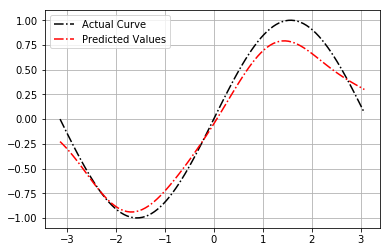

In [10]:
def g(x,x_basis,a) :
    o = 0.0
    for d in range(dset.N):
        o += a[d] * rbf(x,x_basis[d],kernal_sigma2)
    return o

y_pred = []
for x in dset.x_dense :
    y_pred.append( g(x,dset.x,a) )
y_pred = np.array( y_pred )

pp.plot( dset.x_dense,dset.y_dense,'k-.', label='Actual Curve' )
pp.plot( dset.x_dense, y_pred, 'r-.', label='Predicted Values')
pp.legend()
pp.grid()

### Questions

1. How does changing $\sigma^2$ changes the shape of the predicted curve?
2. What other basis functions can we use?
3. How can we measure the error of this prediction?